# Project Description

This project will use both unsupervised and supervised models to classify BBC news articles into into one of five labels: business, entertainment, politics, sport, or tech. The dataset is broken into 1490 records for training and 735 for testing.


# 1. Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [42]:
# First, import the needed packages
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.decomposition import NMF
import itertools
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")


In [43]:
# Import data
df_train = pd.read_csv('BBC News Train.csv')
df_test_x = pd.read_csv('BBC News Test.csv')
df_test_solution = pd.read_csv('BBC News Sample Solution.csv')

## 1.1 Let's first inspect the data. 

Checking the structure, the overall look, and checking wether the test_data entries are in 
the same order as the solution. We also check the missing values, the empty cells in the data, and whether they are duplicate
entries in the data. All the initial data inspection suggests that we have a relatively clean dataset. Then we can
continue to do more exploratory data analyses.

In [45]:
# Exploratory Data Analysis
print(df_train.head())
print(df_test_x.head())
print(df_test_solution.head())

   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business
   ArticleId                                               Text
0       1018  qpr keeper day heads for preston queens park r...
1       1319  software watching while you work software that...
2       1138  d arcy injury adds to ireland woe gordon d arc...
3        459  india s reliance family feud heats up the ongo...
4       1020  boro suffer morrison injury blow middlesbrough...
   ArticleId       Category
0       1018          sport
1       1319           tech
2       1138       business
3        459  entertainment
4       1020       politics


In [46]:
print(df_test_x['ArticleId'] == df_test_solution['ArticleId']) # they are in the same order

0      True
1      True
2      True
3      True
4      True
       ... 
730    True
731    True
732    True
733    True
734    True
Name: ArticleId, Length: 735, dtype: bool


In [47]:
print(df_train.info(), df_test_x.info(), df_test_solution.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Category   735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None None None


In [48]:
df_train.isna().sum() # check for missing values

ArticleId    0
Text         0
Category     0
dtype: int64

In [49]:
df_train.isnull().any(axis=1).sum() # check for any empty rows

0

In [50]:
df_train['ArticleId'].nunique() # check for duplicate rows

1490

## 1.2 Visualize the number of BBC articles by categories

The result shows that he number of articles for each category seem to be relatively balanced, which is an advantage. 
If our dataset were imbalanced, we would need to carefully configure our model or artificially balance the dataset, 
for example by undersampling or oversampling each class.

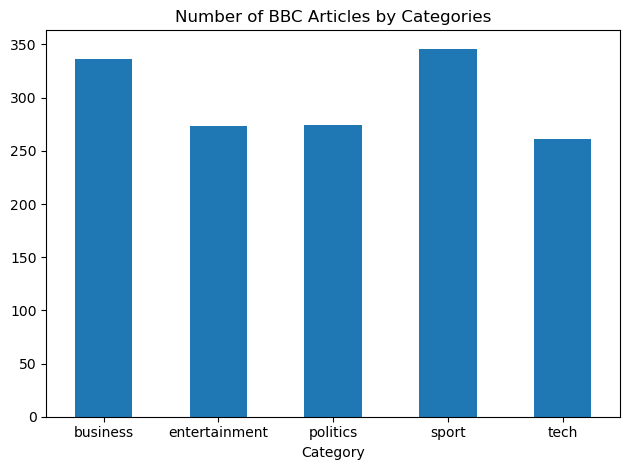

In [7]:
# Histogram of the Category variable
# get the category counts

category_counts = df_train.groupby('Category').size()
# plot the category distribution
ax = category_counts.plot(kind='bar')
plt.title('Number of BBC Articles by Categories')
ax.set_xticklabels(category_counts.index)
plt.xticks(rotation='horizontal')
plt.tight_layout()
plt.show()


## 1.3 Text Preprocessing 

We will use Term Frequency — Inverse Document Frequency (TF-IDF) to convert the text to word embedding. 

TF-IDF is used widely for text classification. It is a numerical representation of the importance of a term (word) in a document within a collection of documents. TF (Term Frequency) measures how frequently a term appears in a document. It indicates the importance of a term within a document. If a term appears more often in a document, its TF value will be higher. 

IDF (Inverse Document Frequency) measures how important a term is in the entire collection of documents. It helps to identify terms that are relatively rare and have higher significance. Terms that appear in fewer documents will have a higher IDF value.

The TF-IDF score is calculated by multiplying the TF value and IDF value for each term in a document. The resulting score reflects the relevance of the term to the document and the entire collection of documents.

In [51]:
# first step, using Term Frequency — Inverse Document Frequency (TF-IDF) to word embedding 

# Create an instance of TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english') # using stop words to exclude "the", "so", "a", etc

# Fit and transform the 'text' column of the dataframe
vectors = vectorizer.fit_transform(df_train['Text'])

feature_names = vectorizer.get_feature_names()

# Convert the vectors to a dense matrix
dense = vectors.todense()

# Convert the dense matrix to a list
denselist = dense.tolist()

# Create a new dataframe with TF-IDF values
new_df_train = pd.DataFrame(denselist, columns=feature_names)

# Concatenate the new dataframe with the original dataframe
df_train = pd.concat([df_train, new_df_train], axis=1)



In [52]:
print(df_train.head()) # here we can see the results of TF-IDF

   ArticleId                                               Text  Category  \
0       1833  worldcom ex-boss launches defence lawyers defe...  business   
1        154  german business confidence slides german busin...  business   
2       1101  bbc poll indicates economic gloom citizens in ...  business   
3       1976  lifestyle  governs mobile choice  faster  bett...      tech   
4        917  enron bosses in $168m payout eighteen former e...  business   

    00       000  0001  000bn  000m  000th  001  ...  zonealarm  zones  zoom  \
0  0.0  0.000000   0.0    0.0   0.0    0.0  0.0  ...        0.0    0.0   0.0   
1  0.0  0.000000   0.0    0.0   0.0    0.0  0.0  ...        0.0    0.0   0.0   
2  0.0  0.023202   0.0    0.0   0.0    0.0  0.0  ...        0.0    0.0   0.0   
3  0.0  0.019446   0.0    0.0   0.0    0.0  0.0  ...        0.0    0.0   0.0   
4  0.0  0.000000   0.0    0.0   0.0    0.0  0.0  ...        0.0    0.0   0.0   

   zooms  zooropa  zorro  zuluaga  zurich  zutons  zvona

In [54]:
# Visualize the top ten key words for each category
columns_to_exclude = ['ArticleId', 'Text']
columns_to_calculate_mean = [col for col in df_train.columns if col not in columns_to_exclude]

avg_tfidf = df_train.groupby('Category')[columns_to_calculate_mean].mean()

# Extract the top ten keywords for each category:
top_keywords = {}
for category, data in avg_tfidf.iterrows():
    top_keywords[category] = data.nlargest(10).index.tolist()
# Create markdown table
table = "| Category | Keywords |\n"
table += "| --- | --- |\n"

for category, keywords in top_keywords.items():
    keywords_str = ', '.join(keywords)
    table += f"| {category} | {keywords_str} |\n"

# Print markdown table
# print(table)

### 1.3.1 Top-10 key words

The table below summarizes the top ten key words for each category in the training dataset, based on the average value of
TF-IDF. As we can see, for each category, the top ten key words are quite relevant. This shows that the TF-IDF metrics is
indeed meaningful for us, and thus it can be used later for modelling.

| Category | Top-10 Keywords |
| --- | --- |
| business | said, growth, economy, bank, market, year, firm, mr, oil, sales |
| entertainment | film, best, music, said, awards, band, actor, award, album, star |
| politics | mr, labour, said, election, blair, party, government, brown, minister, howard |
| sport | england, game, win, said, cup, chelsea, team, match, players, season |
| tech | people, mobile, said, software, users, technology, microsoft, net, phone, digital |

# 2. Building and training models

Firstly, We should not use texts from the test dataset as the input matrix, because we want to train the model with the training data, and then we want to use the test dataset as a way to measure the performance of the model.


## 2.1 Build a model using the matrix factorization method(s) and predict the train and test data labels.

In [55]:

# Apply NMF
nmf = NMF(n_components=5)  # Set the number of components to 5 for 5 categories
W = nmf.fit_transform(new_df_train)  # Fit NMF and obtain basis matrix W

In [56]:

def label_permute_compare(ytdf,yp,n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    # onvert ytdf to a NumPy array
    true_labels = ytdf.values.flatten()
    
    # Create a dictionary to map unique labels to integers
    label_to_int = {label: i for i, label in enumerate(set(true_labels))}

    # Convert the true labels to integers using the mapping dictionary
    true_labels = np.array([label_to_int[label] for label in true_labels], dtype=int)

    # Compute the number of unique labels
    num_labels = len(set(true_labels))

    # Initialize variables to store the best accuracy and the best permutation
    best_accuracy = 0.0
    best_permutation = None

    # Iterate through all possible permutations of labels
    for permutation in itertools.permutations(range(num_labels)):

        # Permute the predicted labels
        permuted_labels = [permutation[label] for label in yp]

        # Compute the accuracy by comparing with the ground truth labels
        accuracy = sum(1 for i in range(len(true_labels)) 
                       if true_labels[i] == permuted_labels[i]) / len(true_labels)

        # Check if the current permutation has a higher accuracy than the previous best
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_permutation = permutation

        else:
            pass
    return best_permutation, best_accuracy

### 2.1.1 measure the NMF performance for the training data

The accuracy score for the training data is pretty good, at around 0.914. 

(1, 2, 4, 3, 0) 0.9147651006711409
{'business': 0, 'sport': 1, 'politics': 2, 'entertainment': 3, 'tech': 4}


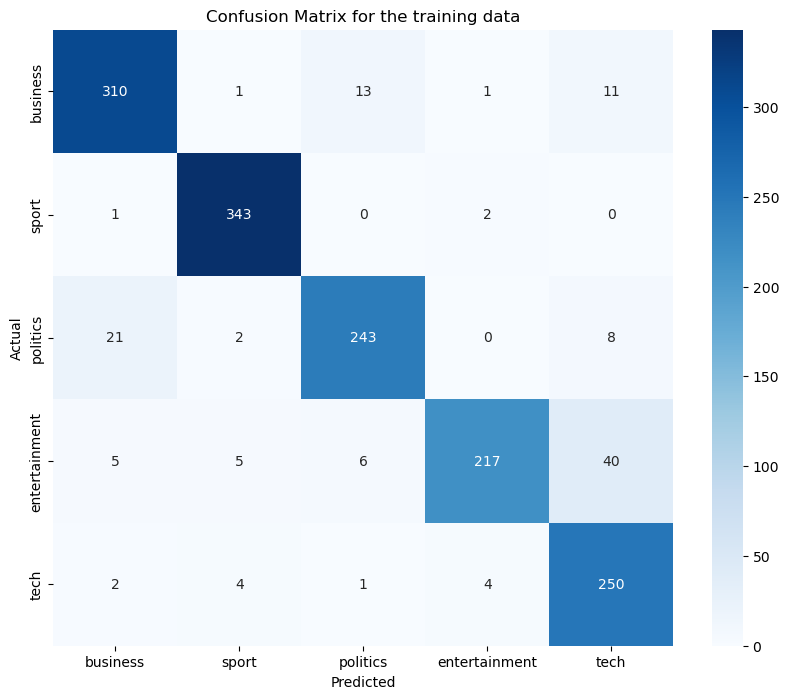

In [57]:
# Obtain the predicted labels from NMF for the training data
cluster_labels = W.argmax(axis=1)
# display confusion matrix here 
labels_df = pd.DataFrame(df_train['Category'])
labelorder, acc = label_permute_compare(labels_df, cluster_labels)
print(labelorder, acc)
true_labels = labels_df.values.flatten()
# Create a dictionary to map unique labels to integers
label_to_int = {label: i for i, label in enumerate(set(true_labels))}
print(label_to_int)
# Convert the true labels to integers using the mapping dictionary
true_labels = [label_to_int[label] for label in true_labels]
predicted_labels = [labelorder[label] for label in cluster_labels]
cm = confusion_matrix(true_labels, predicted_labels)
#print(cm)
# Define the category labels in the right order
labels = sorted(label_to_int, key=label_to_int.get)

# Create a DataFrame from the confusion matrix
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

# Create a heatmap with labels
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')

# Set the axis labels
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Set the title
plt.title('Confusion Matrix for the training data')

# Show the plot
plt.show()

# Print the permutation and accuracy
#print("Permutation:", labelorder)
#print("Accuracy:", acc)


### 2.1.2 measure the NMF performance for the test data
However, as we can see, the NMF accuracy for the test data is extremly low.

(0, 4, 2, 3, 1) 0.22312925170068026
{'business': 0, 'sport': 1, 'politics': 2, 'entertainment': 3, 'tech': 4}


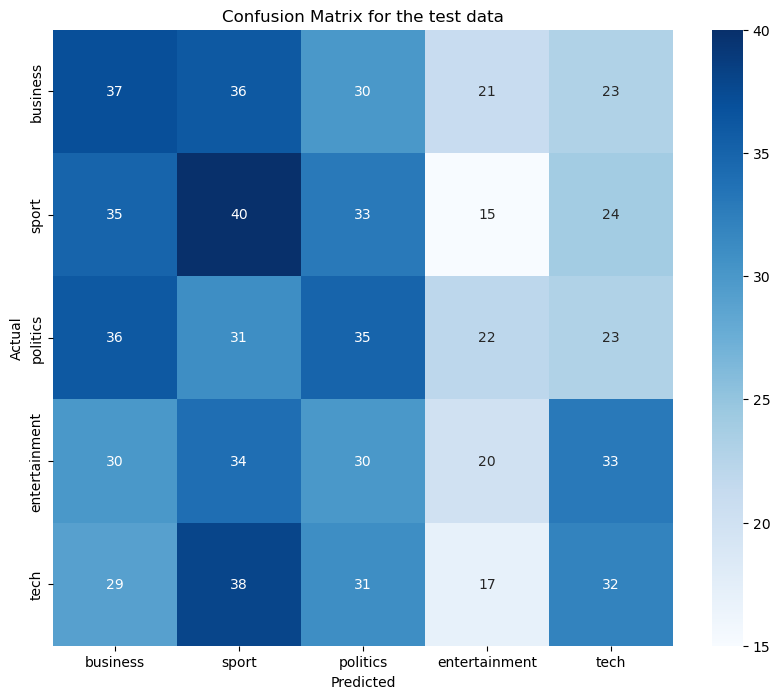

In [58]:
# measure the performance for the test data
# apply NMF transformation for the test data
# Transform the new data with the fitted models
new_df_test = vectorizer.transform(df_test_x['Text'])
W_test = nmf.transform(new_df_test)
# Obtain the cluster labels from NMF for the test data:
cluster_labels_test = [np.argsort(each)[::-1][0] for each in W_test]
labels_df = pd.DataFrame(df_test_solution['Category'])
labelorder, acc = label_permute_compare(labels_df, cluster_labels_test)
print(labelorder, acc)
true_labels = labels_df.values.flatten()
# Create a dictionary to map unique labels to integers
label_to_int = {label: i for i, label in enumerate(set(true_labels))}
print(label_to_int)
# Convert the true labels to integers using the mapping dictionary
true_labels = [label_to_int[label] for label in true_labels]
predicted_labels = [labelorder[label] for label in cluster_labels_test]
cm = confusion_matrix(true_labels, predicted_labels)
#print(cm)
# Define the category labels in the right order
labels = sorted(label_to_int, key=label_to_int.get)

# Create a DataFrame from the confusion matrix
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

# Create a heatmap with labels
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')

# Set the axis labels
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Set the title
plt.title('Confusion Matrix for the test data')

# Show the plot
plt.show()

# Print the permutation and accuracy
#print("Permutation:", labelorder)
#print("Accuracy:", acc)



## 2.2 Hyperpamater tuning

Unfortunately, my computer crashed when I tried to use GridSearchCV to tune my hyperparameters. Therefore, I have drawn inspiration from https://www.kaggle.com/code/robinlutter/bbc-news-classification-nmf-vs-supervised#5.-Compare-with-Supervised-Learning and then use the tuned hyperparameters accordingly. However, the tuned NMF model does not improve the performance for the test dataset.


(1, 2, 4, 3, 0) 0.9214765100671141
{'business': 0, 'sport': 1, 'politics': 2, 'entertainment': 3, 'tech': 4}


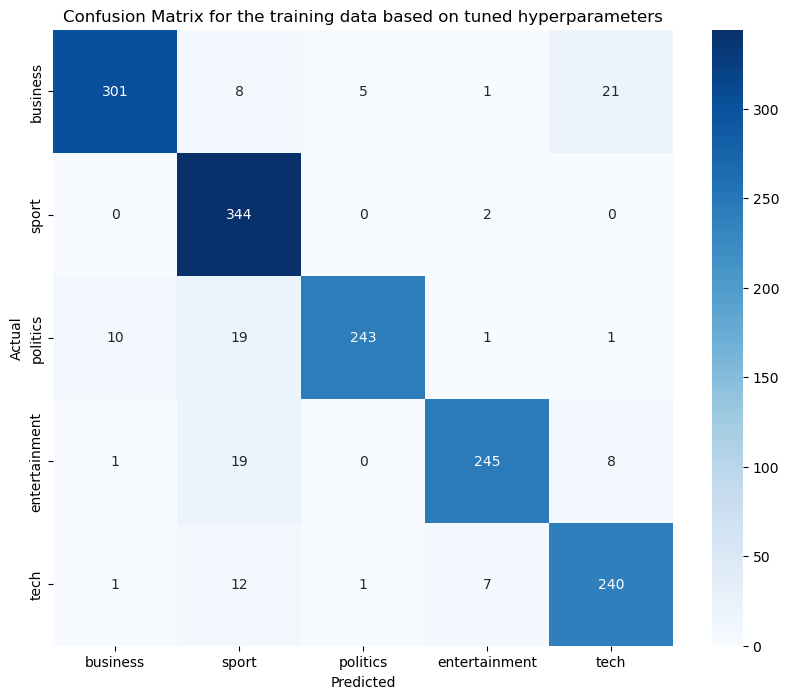

In [59]:
# Pamarater tuning, takes too long time, inspiration from 
# https://www.kaggle.com/code/robinlutter/bbc-news-classification-nmf-vs-supervised#5.-Compare-with-Supervised-Learning
nmf = NMF(n_components=5, beta_loss = 'kullback-leibler', solver = 'mu')
W = nmf.fit_transform(new_df_train)
# Obtain the predicted labels from NMF for the training data
cluster_labels = W.argmax(axis=1)
# display confusion matrix here 
labels_df = pd.DataFrame(df_train['Category'])
labelorder, acc = label_permute_compare(labels_df, cluster_labels)
print(labelorder, acc)
true_labels = labels_df.values.flatten()
# Create a dictionary to map unique labels to integers
label_to_int = {label: i for i, label in enumerate(set(true_labels))}
print(label_to_int)
# Convert the true labels to integers using the mapping dictionary
true_labels = [label_to_int[label] for label in true_labels]
predicted_labels = [labelorder[label] for label in cluster_labels]
cm = confusion_matrix(true_labels, predicted_labels)
#print(cm)
# Define the category labels in the right order
labels = sorted(label_to_int, key=label_to_int.get)

# Create a DataFrame from the confusion matrix
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

# Create a heatmap with labels
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')

# Set the axis labels
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Set the title
plt.title('Confusion Matrix for the training data based on tuned hyperparameters')

# Show the plot
plt.show()

# Print the permutation and accuracy
#print("Permutation:", labelorder)
#print("Accuracy:", acc)


(0, 4, 1, 2, 3) 0.22993197278911565
{'business': 0, 'sport': 1, 'politics': 2, 'entertainment': 3, 'tech': 4}


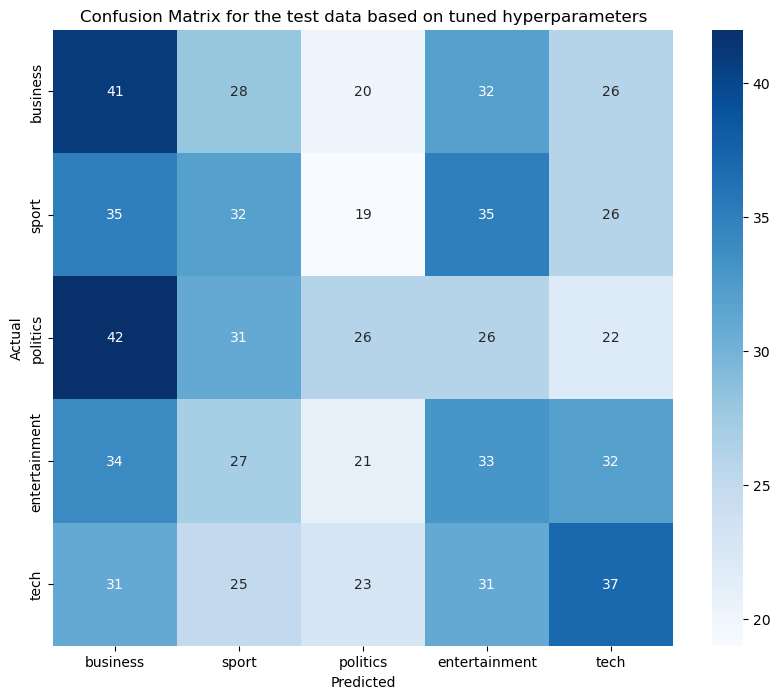

In [60]:
new_df_test = vectorizer.transform(df_test_x['Text'])
W_test = nmf.transform(new_df_test)
# Obtain the cluster labels from NMF for the test data:
cluster_labels_test = [np.argsort(each)[::-1][0] for each in W_test]
labels_df = pd.DataFrame(df_test_solution['Category'])
labelorder, acc = label_permute_compare(labels_df, cluster_labels_test)
print(labelorder, acc)
true_labels = labels_df.values.flatten()
# Create a dictionary to map unique labels to integers
label_to_int = {label: i for i, label in enumerate(set(true_labels))}
print(label_to_int)
# Convert the true labels to integers using the mapping dictionary
true_labels = [label_to_int[label] for label in true_labels]
predicted_labels = [labelorder[label] for label in cluster_labels_test]
cm = confusion_matrix(true_labels, predicted_labels)
#print(cm)
# Define the category labels in the right order
labels = sorted(label_to_int, key=label_to_int.get)

# Create a DataFrame from the confusion matrix
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

# Create a heatmap with labels
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')

# Set the axis labels
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Set the title
plt.title('Confusion Matrix for the test data based on tuned hyperparameters')

# Show the plot
plt.show()

# Print the permutation and accuracy
#print("Permutation:", labelorder)
#print("Accuracy:", acc)

## 2.3 Varying training data size

Another way to improve the model performance is to fit models in different subsets of data. However, it does not seem to help in this case. And the accuracy score for the test data remains very low. This indicates that NMF may not be a good model to use for the data, or indicate that other kinds of text preprocessing procedures are needed.

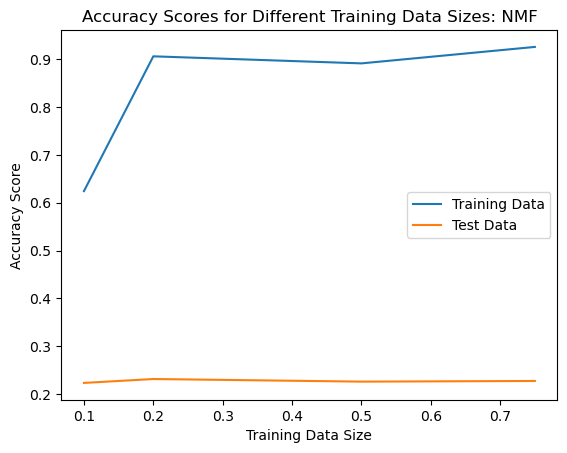

In [61]:
# Varying training data size
# Define the different training data sizes as a percentage of the original training data
data_sizes = [0.1, 0.2, 0.5, 0.75]

# Initialize lists to store the accuracy scores
train_scores = []
test_scores = []

# Loop over the different data sizes
for size in data_sizes:
    # Split the original training data into subsets
    X_train_subset, _, y_train_subset, _ = train_test_split(new_df_train, df_train['Category'], 
                                                            train_size=size, random_state=42)
    
    nmf = NMF(n_components=5, beta_loss = 'kullback-leibler', solver = 'mu')
    W = nmf.fit_transform(X_train_subset)
    # Obtain the predicted labels from NMF for the training data
    cluster_labels = W.argmax(axis=1)
    # display confusion matrix here 
    labels_df = pd.DataFrame(y_train_subset)
    labelorder, acc = label_permute_compare(labels_df, cluster_labels)
    
    # Measure the accuracy on the training data subset
    train_accuracy = acc
    
    new_df_test = vectorizer.transform(df_test_x['Text'])
    W_test = nmf.transform(new_df_test)
    # Obtain the cluster labels from NMF for the test data:
    cluster_labels_test = [np.argsort(each)[::-1][0] for each in W_test]
    labels_df = pd.DataFrame(df_test_solution['Category'])
    labelorder, acc2 = label_permute_compare(labels_df, cluster_labels_test)
    # Measure the accuracy on the test data
    test_accuracy = acc2
    
    # Store the accuracy scores
    train_scores.append(train_accuracy)
    test_scores.append(test_accuracy)

# Visualize the accuracy scores
plt.plot(data_sizes, train_scores, label='Training Data')
plt.plot(data_sizes, test_scores, label='Test Data')
plt.xlabel('Training Data Size')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores for Different Training Data Sizes: NMF')
plt.legend()
plt.show()

# 3. Compare with supervised learning 


## 3.1 Train a supervised learning method: LogisticRegression

The result shows that the supervised logistical regression model has a better accuracy score for the training dataset, but has a lower accuracy score for the test dataset. This suggests that there might be some overfitting issues.

In [62]:
# Train a supervised learning method: LogisticRegression

# Create an instance of LogisticRegression
logistic_classifier = LogisticRegression()

# Fit the classifier to your data
logistic_classifier.fit(new_df_train, df_train['Category'])

# Measure the accuracy on the training data
accuracy = logistic_classifier.score(new_df_train, df_train['Category'])

print("Accuracy for the training data:", accuracy)

Accuracy for the training data: 0.9979865771812081


In [63]:
# On the test data
# Apply the trained model to the test data
y_pred = logistic_classifier.predict(new_df_test)

# Measure the accuracy on the test data
accuracy = logistic_classifier.score(new_df_test, df_test_solution['Category'])

print("Accuracy for the test data:", accuracy)

Accuracy for the test data: 0.19319727891156463


## 3.2 Varying training data size for the logistical regression

As with NMF, we can also vary the different size of the training data. The result shows that for logistical regression models,
different training sizes do not seem to influence the accuracy score much in this case. 

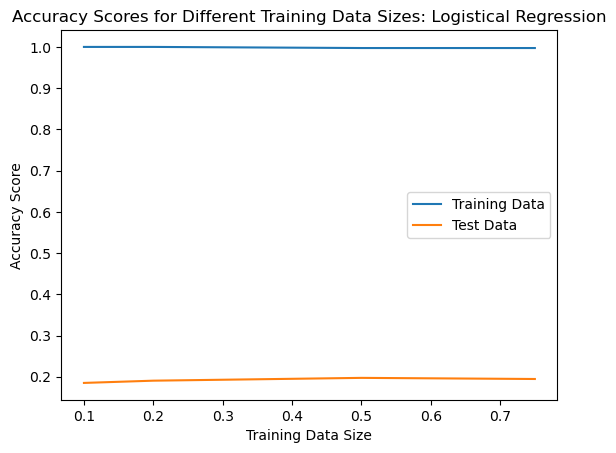

In [64]:
# Varying training data size

# Define the different training data sizes as a percentage of the original training data
data_sizes = [0.1, 0.2, 0.5, 0.75]

# Initialize lists to store the accuracy scores
train_scores = []
test_scores = []

# Loop over the different data sizes
for size in data_sizes:
    # Split the original training data into subsets
    X_train_subset, _, y_train_subset, _ = train_test_split(new_df_train, df_train['Category'], train_size=size, random_state=42)
    
    # Create an instance of LogisticRegression
    logistic_classifier = LogisticRegression()
    
    # Fit the classifier to the training data subset
    logistic_classifier.fit(X_train_subset, y_train_subset)
    
    # Measure the accuracy on the training data subset
    train_accuracy = logistic_classifier.score(X_train_subset, y_train_subset)
    
    # Measure the accuracy on the test data
    test_accuracy = logistic_classifier.score(new_df_test, df_test_solution['Category'])
    
    # Store the accuracy scores
    train_scores.append(train_accuracy)
    test_scores.append(test_accuracy)

# Visualize the accuracy scores
plt.plot(data_sizes, train_scores, label='Training Data')
plt.plot(data_sizes, test_scores, label='Test Data')
plt.xlabel('Training Data Size')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores for Different Training Data Sizes: Logistical Regression')
plt.legend()
plt.show()


# 4. Conclusion

Firstly, TF-IDF is indeed a meaningful approach to classify text into different categories. It takes into account the importance of terms within a document and the entire collection of documents, providing a way to identify key terms that can help in classification tasks.

Secondly, the NMF model performs well on the training dataset but poorly on the test dataset. This can happen when the model overfits the training data and fails to generalize well to unseen data. Overfitting occurs when the model learns the specific patterns and noise in the training data too well, leading to poor performance on new data.

Thirdly, logistic regression can have higher accuracy scores on the training dataset due to their ability to learn from labeled data. However, they may suffer from overfitting, especially when the model complexity is high relative to the amount of training data. This can lead to lower accuracy scores on the test dataset compared to the NMF model, which is an unsupervised model.

Fourthly, the impact of different training dataset sizes on model performance can vary between models. It seems that the NMF model is more data-efficient and benefits from larger training datasets, leading to improved accuracy scores. On the other hand, the logistic regression model may not be as sensitive to changes in training dataset size, resulting in relatively consistent accuracy scores.

# Reference list:

https://towardsdatascience.com/tf-idf-explained-and-python-sklearn-implementation-b020c5e83275

https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76

https://www.kaggle.com/code/robinlutter/bbc-news-classification-nmf-vs-supervised#5.-Compare-with-Supervised-Learning

https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification

https://www.kaggle.com/code/rockystats/topic-modelling-using-nmf
